In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import time
import copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from model import CNNModel

In [29]:
num_trainers = 3

In [30]:
def touch(filename):
    open(filename, 'a').close()

In [31]:
def average_weights(w):
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg

In [32]:
# Create Initial Model and send to trainer with start train instruction
global_model = CNNModel()

for i in range(1, num_trainers + 1):
    torch.save(global_model.state_dict(), 'models/global_trainer' + str(i) + '.pt')
    touch('models/start_training' + str(i))

In [33]:
df_test = pd.read_csv('data/mnist_test.csv')
X_test = df_test.iloc[:, 1:]
y_test = df_test.iloc[:, :1]

print('Labels in this test set: ', df_test['label'].unique())
print(X_test.shape)
print(y_test.shape)

Labels in this test set:  [7 2 1 0 4 9 5 6 3 8]
(10000, 784)
(10000, 1)


In [34]:
X_test = np.array(X_test).reshape(X_test.shape[0], 784)

X_test = np.array(X_test.reshape(X_test.shape[0], X_test.shape[1]))
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_test = torch.from_numpy(X_test).float()

y_test = np.array(y_test)
y_test = y_test.reshape(y_test.shape[0])
y_test = torch.from_numpy(np.array(y_test))
print(X_test.shape, y_test.shape)

torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [35]:
batch_size = 100

test = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [ ]:
accuracy_list = []

total = 0
correct = 0
num_epochs = 100

max_time_to_wait = 600 #seconds

for epoch in range(num_epochs):
    
    wait_counter = 0
    timeout = False

    for i in range(1, num_trainers + 1):
        trainer_model_file = 'models/trainer' + str(i) + '_cnn.pt'
        while not os.path.exists(trainer_model_file):
            if wait_counter > max_time_to_wait:
                timeout = True
                break
            
            if wait_counter % 60 == 0:
                print('Waiting for models from trainers...')
            
            time.sleep(1)
            wait_counter = wait_counter + 1
            
    if timeout:
        # Write code to retry training. This code is not fault tolerant
        print('Placeholder to retry training.')
        break
    else:
        print('Got models from all trainers.')
    
    worker_models = []
    for i in range(1, num_trainers + 1):
        trainer_model_file = 'models/trainer' + str(i) + '_cnn.pt'
        global_model.load_state_dict(torch.load(trainer_model_file))
        worker_models.append(copy.deepcopy(global_model.state_dict()))
        
        # remove the trainer mode after loading weights
        os.remove(trainer_model_file)
        print('Loaded model: ', trainer_model_file)
        
    global_weights = average_weights(worker_models)
    
    # Load global model for evaluation
    global_model.load_state_dict(global_weights)
    global_model.eval()
    for test_images, labels in test_loader:
        # Forward propagation
        outputs = global_model(test_images)
        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]

        # Total number of labels
        total += len(labels)
        correct += (predicted == labels).sum()

    accuracy = 100 * correct / float(total)
    
    print('Epoch: {} Accuracy: {} %'.format(epoch+1, accuracy))
    
    # Write averaged global model for trainers to train again
    if epoch < num_epochs-1:
        for i in range(1, num_trainers + 1):
            torch.save(global_model.state_dict(), 'models/global_trainer' + str(i) + '.pt')
            touch('models/start_training' + str(i))
    
    # Save global model for future
    torch.save(global_model.state_dict(), 'models/global_model.pt')
    
# Send stop signals to all trainers
for i in range(1, num_trainers + 1):
    touch('models/stop_training' + str(i))
print('Completed Training.')    

Waiting for models from trainers...
Got models from all trainers.
Loaded model:  models/trainer1_cnn.pt
Loaded model:  models/trainer2_cnn.pt
Loaded model:  models/trainer3_cnn.pt
Epoch: 1 Accuracy: 25.079999923706055 %
Waiting for models from trainers...
Waiting for models from trainers...
Got models from all trainers.
Loaded model:  models/trainer1_cnn.pt
Loaded model:  models/trainer2_cnn.pt
Loaded model:  models/trainer3_cnn.pt
Epoch: 2 Accuracy: 21.3799991607666 %
Waiting for models from trainers...
Waiting for models from trainers...
Got models from all trainers.
Loaded model:  models/trainer1_cnn.pt
Loaded model:  models/trainer2_cnn.pt
Loaded model:  models/trainer3_cnn.pt
Epoch: 3 Accuracy: 27.850000381469727 %
Waiting for models from trainers...
Got models from all trainers.
Loaded model:  models/trainer1_cnn.pt
Loaded model:  models/trainer2_cnn.pt
Loaded model:  models/trainer3_cnn.pt
Epoch: 4 Accuracy: 29.052499771118164 %
Waiting for models from trainers...
Got models fro

In [37]:
# Look at the trained model
global_model.load_state_dict(torch.load('models/global_model.pt'))


<All keys matched successfully>

Prediction:  1


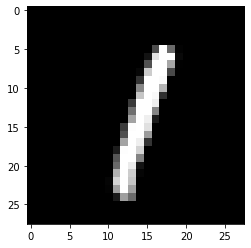

In [45]:
X_test = df_test.iloc[:, 1:]
y_test = df_test.iloc[:, :1]

X_test = np.array(X_test).reshape(X_test.shape[0], 784)

sample = 5
img = X_test[sample] #shape (784,1)
img = img.reshape(1, 1, 28, 28) #shape (1,1,28,28)
img  = torch.from_numpy(img).float() #tensor

prediction = global_model(img).detach().numpy()[0].argmax()
print('Prediction: ', prediction)

# Look at the real picture
fig = plt.figure
plt.imshow(X_test[sample].reshape(28,28), cmap='gray')
plt.show()